In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
from _plotly_future_ import v4_subplots
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
import plotly.plotly as py

# Initialize plotly
init_notebook_mode(connected=True)

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
import IPython

IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

## Analyzing TS

In [21]:
df_train = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')

df_train['date'] = pd.to_datetime(df_train['date'], infer_datetime_format=True)
df_train = df_train.set_index(['date'])

df_test['date'] = pd.to_datetime(df_test['date'], infer_datetime_format=True)
df_test = df_test.set_index(['date'])

df_test.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-04-20,34.500,27.500000,5.562500,998.625000
2017-04-21,34.250,39.375000,6.962500,999.875000
2017-04-22,32.900,40.900000,8.890000,1001.600000
2017-04-23,32.875,27.500000,9.962500,1002.125000
2017-04-24,32.000,27.142857,12.157143,1004.142857


In [23]:
print("test set")
print(df_test.isna().sum())
print("\n")
print("train set")
print(df_train.isna().sum())

test set
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


train set
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [24]:
def make_list_to_fix(df):
    d=[]
    for idx,i in enumerate(df['meanpressure'].values):
        if i < 870 or i > 1084:
             d.append((idx,i))
    return d     


In [25]:
def fix_meanpressure(df, list_to_fix):
    data = df['meanpressure'].values
    for idx,_ in list_to_fix:
        data = np.delete(data,idx)
    mean = data.mean()
    for idx, _ in list_to_fix:
        df['meanpressure'][idx] = mean

fix_meanpressure(df_train, make_list_to_fix(df_train))
fix_meanpressure(df_test, make_list_to_fix(df_test))

### Histogram

In [26]:
from plotly.subplots import make_subplots

def plot_hist(df_train, df_test):
    fig=make_subplots(rows=4, cols=2)
    
    i=0
    for a in df_train.columns:
        fig.append_trace(go.Histogram(
            x=df_train[a].values,
            name=a+"_train"
        ), row=i+1, col=1)
        i += 1
        
    i=0    
    for a in df_train.columns:
        fig.append_trace(go.Histogram(
            x=df_test[a].values,
            name=a+"_test"
        ), row=i+1, col=2)
        i += 1
    
    fig.show()
            
plot_hist(df_train, df_test)


In [27]:
df_full = pd.concat([df_train, df_test], ignore_index=False)

### Wykres wartości

In [28]:
from plotly.subplots import make_subplots

def plot_all(df):
    fig=make_subplots(rows=4, cols=1)
    
    fig.append_trace(go.Scatter(
        x=pd.to_datetime(df.index.values),
        y=df['meantemp'],
        name='meantemp'
    ), row=1, col=1)
    
    fig.append_trace(go.Scatter(
        x=pd.to_datetime(df.index.values),
        y=df['humidity'],
        name='humidity'
    ), row=2, col=1)
    
    fig.append_trace(go.Scatter(
        x=pd.to_datetime(df.index.values),
        y=df['wind_speed'],
        name='wind_speed'
    ), row=3, col=1)
    
    fig.append_trace(go.Scatter(
        x=pd.to_datetime(df.index.values),
        y=df['meanpressure'],
        name='meanpressure'
    ), row=4, col=1)
    
    fig.show()
    
plot_all(df_full)

### dekompozycja

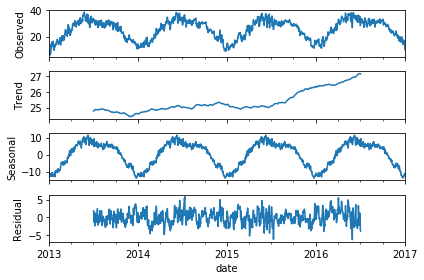

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_train['meantemp'], model='additive', freq = 365)
result.plot();


In [31]:
def plot_mean_std(df,window_size):
    rollmean = df.rolling(window=window_size).mean()
    rollstd = df.rolling(window=window_size).std()
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=pd.to_datetime(df.index.values),
        y=df['meantemp'],
        name='meantemp'
    ))
    
    fig.add_trace(go.Scatter(
        x=pd.to_datetime(df.index.values),
        y=rollstd['meantemp'],
        name='rollstd'
    )) 
        
    fig.add_trace(go.Scatter(
        x=pd.to_datetime(df.index.values),
        y=rollmean['meantemp'],
        name='rollmean'
    ))
    
    fig.show()
    
plot_mean_std(df_train,window_size=180)

In [32]:
corr = df_full.corr()
corr.style.background_gradient(cmap='coolwarm')

,meantemp,humidity,wind_speed,meanpressure
meantemp,1,-0.574849,0.288088,-0.849758
humidity,-0.574849,1,-0.373602,0.328779
wind_speed,0.288088,-0.373602,1,-0.258998
meanpressure,-0.849758,0.328779,-0.258998,1


## Feature Engineering

In [33]:
def feature_eng(df):
    df_add_feature = df
    df_add_feature['hum_2'] = df['humidity'] * df['humidity']
    df_add_feature['press_2'] = df['meanpressure'] * df['meanpressure']
    df_add_feature['hum_div_press'] = df['meanpressure'] / df['humidity']
    df_add_feature['hum_mult_press'] = df['meanpressure'] * df['humidity']
    df_add_feature['hum_mult_wind'] = df['wind_speed'] * df['humidity']
    
    return df_add_feature

## ACF & PACF plots

In [34]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

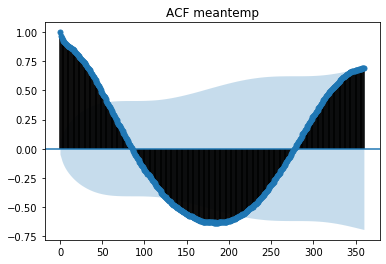

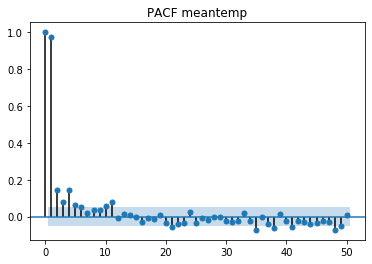

In [35]:
plot_acf(df_train['meantemp'], lags=360, title="ACF meantemp");
plot_pacf(df_train['meantemp'], lags=50, title = "PACF meantemp");

## TEST ADF & KPSS

In [36]:
from statsmodels.tsa.stattools import adfuller

def adf_test (df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_test(df_train["meantemp"])

Test Statistic                   -2.021069
p-value                           0.277412
#Lags Used                       10.000000
Number of Observations Used    1451.000000
Critical Value (1%)              -3.434865
Critical Value (5%)              -2.863534
Critical Value (10%)             -2.567832
dtype: float64


In [37]:
from statsmodels.tsa.stattools import kpss

def kpss_test (df):
    kpsstest = kpss(df, lags='auto', regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index =['Test Statistic', 'p-value','Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)
    
kpss_test(df_train["meantemp"])

Test Statistic            0.187864
p-value                   0.100000
Lags Used                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/adam/DEV/python/zadanie_dhi/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



## Naive forecast

In [38]:
from datetime import timedelta, datetime


In [39]:
def create_naive_prediction(df_test, step):
    forecast = df_test['meantemp'].copy(deep=True)
    
    for i in range(0, (df_test.count()[1])//3):
        lower_idx = i*step
        upper_idx = lower_idx + 3
        forecast[lower_idx:upper_idx] = [forecast[lower_idx]] * step
        
    return forecast

naive_predict = create_naive_prediction(df_test, 3)

In [40]:
def create_sesonal_naive_prediction(df_test,
                                    df_train,
                                    step=3,
                                    sesonal_mean=False,
                                    sesonal_cycle = 365,
                                    number_of_sesons=4,
                                    series_to_predict = 'meantemp'
                                   ):
    
    forecast = df_test[series_to_predict].copy(deep=True)
    sesonal_value = 0
    
    for i in range(0, (df_test.count()[1])//step):
        date_index = df_test.index[i+step]
        if not sesonal_mean: 
            sesonal_index = date_index - timedelta(days=sesonal_cycle)
            sesonal_value = df_train[series_to_predict].loc[sesonal_index]
        else :
            for j in range (0,number_of_sesons):
                sesonal_index = date_index - timedelta(days=365)
                sesonal_value += df_train[series_to_predict].loc[sesonal_index]
            sesonal_value /= number_of_sesons
             
        
        lower_idx = i*step
        upper_idx = lower_idx + 3
        forecast[lower_idx:upper_idx] = [sesonal_value] * step
        
    return forecast

s_naive_predict = create_sesonal_naive_prediction(df_test, df_train, 3, sesonal_mean=True)      

In [41]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=pd.to_datetime(df_test.index.values),
    y=df_test['meantemp'],
    name='observed'
))

fig.add_trace(go.Scatter(
    x=pd.to_datetime(df_test.index.values),
    y=naive_predict,
    name = 'predict'
))

fig.add_trace(go.Scatter(
    x=pd.to_datetime(df_test.index.values),
    y=s_naive_predict,
    name = 'sesonal_predict'
))

fig.show()

In [42]:
error = np.subtract(df_test['meantemp'],naive_predict)
error_sesonal = np.subtract(df_test['meantemp'],s_naive_predict)
MAE = abs(error).mean()
MAE_s = abs(error_sesonal).mean()
print("MAE: {}".format(MAE))
print("\n")
print("MAE for sesonal_pred : {}".format(MAE_s))

MAE: 1.106728971175725


MAE for sesonal_pred : 5.520590233948329


Metryki:
* RSME
* MAPE
* sMAPE
* MASE

## Zadanie dodatkowe - SARIMA

In [43]:
from statsmodels.tsa.arima_model import ARIMA

def differencing (df, shift_size=1, order=1):
    df_diff = df.copy(deep='True')
    for i in range(0,order):
        df_diff['meantemp'] = df_diff['meantemp'] - df_diff['meantemp'].shift(shift_size)
    return df_diff
        

df_train_temp_diff = differencing(df_train, shift_size=365, order=1)
df_train_temp_diff['meantemp'].dropna().iplot()


In [44]:
adf_test(df_train_temp_diff['meantemp'].dropna())

Test Statistic                -1.005809e+01
p-value                        1.356156e-17
#Lags Used                     3.000000e+00
Number of Observations Used    1.093000e+03
Critical Value (1%)           -3.436347e+00
Critical Value (5%)           -2.864188e+00
Critical Value (10%)          -2.568180e+00
dtype: float64


In [45]:
kpss_test(df_train_temp_diff['meantemp'].dropna())

Test Statistic            1.012971
p-value                   0.010000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/adam/DEV/python/zadanie_dhi/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value



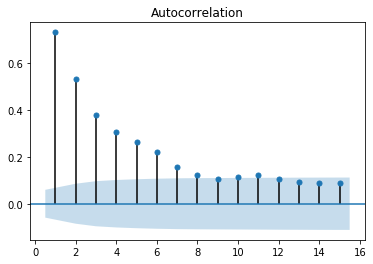

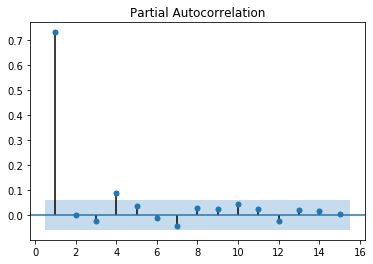

In [46]:
plot_acf(df_train_temp_diff['meantemp'].dropna(), zero=False, lags=15);
plot_pacf(df_train_temp_diff['meantemp'].dropna(), zero=False, lags=15);

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


### Przygotowanie exgo data

In [72]:
df_train = feature_eng(df_train)
df_test = feature_eng(df_test)

exgo_data = df_train.copy(deep=True)
exgo_data = exgo_data.drop(['meantemp'], axis=1)

exgo_data_test = df_test.copy(deep=True)
exgo_data_test = exgo_data_test.drop(['meantemp'], axis=1)



,humidity,wind_speed,meanpressure,hum_2,press_2,hum_div_press,hum_mult_press,hum_mult_wind
date,,,,,,,,
2013-01-01,84.500000,0.000000,1015.666667,7140.250000,1.031579e+06,12.019724,85823.833333,0.000000
2013-01-02,92.000000,2.980000,1017.800000,8464.000000,1.035917e+06,11.063043,93637.600000,274.160000
2013-01-03,87.000000,4.633333,1018.666667,7569.000000,1.037682e+06,11.708812,88624.000000,403.100000
2013-01-04,71.333333,1.233333,1017.166667,5088.444444,1.034628e+06,14.259346,72557.888889,87.977778
2013-01-05,86.833333,3.700000,1016.500000,7540.027778,1.033272e+06,11.706334,88266.083333,321.283333


obliczenia dla m >180 trwają bardzo długo

In [83]:
d = 0
p = 1
q = 4

P = 1
D = 1
Q = 1
m = 30

model = SARIMAX(df_train['meantemp'].dropna(),
                order=(p,d,q),
                seasonal_order=(P,D,Q,m),
                exog= exgo_data,
                enforce_stationarity=False,
                enforce_invertibility=False,
               )
model = model.fit(disp=False)



/home/adam/DEV/python/zadanie_dhi/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [84]:
val = model.forecast(len(df_test), exog=exgo_data_test)

In [85]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=pd.to_datetime(val.index.values),
    y=df_train['meantemp'],
    name='observed'
))

fig.add_trace(go.Scatter(
    x=pd.to_datetime(val.index.values),
    y=val,
    name = 'predict'
))

fig.show()

In [86]:
error_SARIMAX = np.subtract(df_test['meantemp'],val)
MAE_SARIMAX = abs(error_SARIMAX).mean()
print("MAE: {} degree".format(MAE))
print("\n")
print("MAE for sesonal naive pred : {} degree".format(MAE_s))
print("\n")
print("MAE for SARIMAX : {} degree".format(MAE_SARIMAX))


MAE: 1.106728971175725 degree


MAE for sesonal naive pred : 5.520590233948329 degree


MAE for SARIMAX : 2.7747451713561873 degree
